# Kaggle Movies Dataset
Predicting Genre of a movie based on Title,Original Title,TagLine and Description

In [2]:
#Importing Packages
import pandas as pd
import re
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/content/drive/My Drive/Projects/Factset_Recruitment')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Reading The Data
Columns = ['genres','original_title','overview','tagline','title']
MoviesMetaData = pd.read_csv('movies_metadata.csv',usecols =Columns )

In [4]:
# Function to Summarize Data
def summary(data):
  print('Shape of data :',data.shape)
  return(pd.DataFrame({'Dtypes':data.dtypes,
                       'NAs':data.isnull().sum(),
                       'Uniques':data.nunique()}))
  
summary(MoviesMetaData)  

Shape of data : (45466, 5)


,Dtypes,NAs,Uniques
genres,object,0,4069
original_title,object,0,43373
overview,object,954,44307
tagline,object,25054,20283
title,object,6,42277


In [5]:
# Records where OriginalTitle and Title don't match
MoviesMetaData.loc[MoviesMetaData['original_title']!=MoviesMetaData['title'],:][:5]

,genres,original_title,overview,tagline,title
28,"[{'id': 14, 'name': 'Fantasy'}, {'id': 878, 'n...",La Cité des Enfants Perdus,A scientist in a surrealist society kidnaps ch...,Where happily ever after is just a dream.,The City of Lost Children
29,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",摇啊摇，摇到外婆桥,A provincial boy related to a Shanghai crime f...,In 1930's Shanghai violence was not the proble...,Shanghai Triad
32,"[{'id': 10749, 'name': 'Romance'}, {'id': 12, ...","Guillaumet, les ailes du courage",NaN,NaN,Wings of Courage
57,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Il postino,Simple Italian postman learns to love poetry w...,NaN,The Postman
58,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Le confessionnal,"The year is 1952, in Quebec City. Rachel (16),...",NaN,The Confessional


Title is original title in english!, We can drop Original Title and use only title for model building

In [0]:
#Function to Preprocessing Text Inside columns 
stemmer = WordNetLemmatizer()
Stopwords = stopwords.words('english')
def PreProcessData(Mdata):
  data = Mdata.copy()
  data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else '[]')
  data = data.loc[~(data.genres=='[]'),:]
  data = data.loc[~data.title.isnull(),:]
  data.fillna('',inplace=True)
  data.drop('original_title',axis=1,inplace=True)
  data['overview']=data.overview.apply(lambda x:' '.join(stemmer.lemmatize(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in Stopwords ))
  data['tagline']=data.tagline.apply(lambda x:' '.join(stemmer.lemmatize(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in Stopwords ))
  data['title']=data.title.apply(lambda x:' '.join(stemmer.lemmatize(i) for i in re.sub("[^a-zA-Z]"," ",x).split() if i not in Stopwords ))
  return data


In [7]:
MoviesMetaData = PreProcessData(MoviesMetaData)
MoviesMetaData.shape

(45460, 4)

In [8]:
MoviesMetaData.head()

,genres,overview,tagline,title
0,"[Animation, Comedy, Family]",Led Woody Andy toy live happily room Andy birt...,,Toy Story
1,"[Adventure, Fantasy, Family]",When sibling Judy Peter discover enchanted boa...,Roll dice unleash excitement,Jumanji
2,"[Romance, Comedy]",A family wedding reignites ancient feud next d...,Still Yelling Still Fighting Still Ready Love,Grumpier Old Men
3,"[Comedy, Drama, Romance]",Cheated mistreated stepped woman holding breat...,Friends people let never let forget,Waiting Exhale
4,[Comedy],Just George Banks recovered daughter wedding r...,Just When His World Is Back To Normal He In Fo...,Father Bride Part II


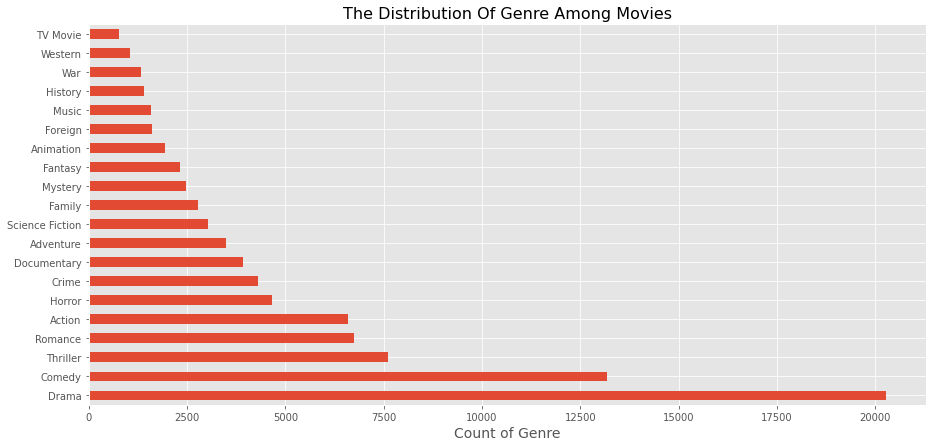

In [9]:
# Understanding The Distribution Of Genres
all_genres = sum(MoviesMetaData.genres,[])
plt.figure(figsize=(15,7))
pd.Series(all_genres).value_counts(ascending=False).plot.barh()
plt.xlabel('Count of Genre',fontsize=14)
plt.title('The Distribution Of Genre Among Movies',fontsize=16)
plt.show()

In [0]:
# Since We Are Dealing With Multilabel Classification Problem Lets Convert Genres Into MultilabelBinary Form 
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(MoviesMetaData['genres'])

# transform target variable
y = multilabel_binarizer.transform(MoviesMetaData['genres'])

In [0]:
# Splitting Train and Test Data And Using Only Overview Field To Predict Genre
xtrain,xtest,ytrain,ytest = train_test_split(MoviesMetaData['overview'],y,test_size=0.2)

In [0]:
# Coverting Text to Numerical Columns Of TFIDF Values of Words, Taking Max 10000 Words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

In [0]:
# Function to Evaluate The Performance Of Model
def EvaluateModel(Model):
  test_pred = Model.predict(xtest_tfidf)
  train_pred = Model.predict(xtrain_tfidf)
  TrainAcc = accuracy_score(ytrain,train_pred)
  TestAcc = accuracy_score(ytest,test_pred)
  print('Train Accuracy :{:.2f} , Test Accuracy :{:.2f}'.format(TrainAcc,TestAcc))
  FScore = f1_score(ytest, test_pred, average="macro")
  Precision=precision_score(ytest, test_pred, average="macro")
  Recall = recall_score(ytest, test_pred, average="macro")
  print('Macro Average Score:')
  print('Precision :{:.2f} , Recall :{:.2f} , F1Score :{:.2f}\n '.format(Precision, Recall, FScore))
  FScore = f1_score(ytest, test_pred, average="micro")
  Precision=precision_score(ytest, test_pred, average="micro")
  Recall = recall_score(ytest, test_pred, average="micro")
  print('Micro Average Score:')
  print('Precision :{:.2f} , Recall :{:.2f} , F1Score :{:.2f} '.format(Precision, Recall, FScore))
  return
  


## Model Building

Logistic Regression GridSearch

In [14]:
lr = LogisticRegression(max_iter=3000 )
clf = OneVsRestClassifier(lr)
params = {'estimator__C':[0.01,1,10],
       'estimator__penalty':['l1','l2'] , 
       'estimator__class_weight':[None,'balanced'],
       }
GridCV_lr = GridSearchCV(clf , param_grid = params , scoring='f1_micro' , n_jobs=-1)
GridCV_lr.fit(xtrain_tfidf, ytrain)
print(GridCV_lr.best_params_)
EvaluateModel(GridCV_lr)

{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2'}
Train Accuracy :0.18 , Test Accuracy :0.09
Macro Average Score:
Precision :0.37 , Recall :0.65 , F1Score :0.47
 
Micro Average Score:
Precision :0.43 , Recall :0.69 , F1Score :0.53 


Linear SVC GridSearchCV

In [26]:
svc = LinearSVC(max_iter=3000 )
clf = OneVsRestClassifier(svc)
params = {'estimator__C':[0.001,0.01,1,10,1000],
       'estimator__penalty':['l1','l2'] , 
       'estimator__class_weight':[None,'balanced'],
       'estimator__dual':[True,False]
       }
GridCV_svc = GridSearchCV(clf , param_grid = params , scoring='f1_micro' , n_jobs=-1)
GridCV_svc.fit(xtrain_tfidf, ytrain)
print(GridCV_svc.best_params_,'\n')
EvaluateModel(GridCV_svc)

{'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__dual': True, 'estimator__penalty': 'l2'}
Train Accuracy :0.10 , Test Accuracy :0.07
Macro Average Score:
Precision :0.34 , Recall :0.68 , F1Score :0.44
 
Micro Average Score:
Precision :0.38 , Recall :0.69 , F1Score :0.49 


Random Forest GridSearch

In [30]:
rf = RandomForestClassifier(class_weight='balanced' )
clf = OneVsRestClassifier(rf)
params = {'estimator__max_depth':[5,10] }
GridCV_rf = GridSearchCV(clf , param_grid = params , scoring='f1_micro' , n_jobs=-1)
GridCV_rf.fit(xtrain_tfidf, ytrain)
print(GridCV_rf.best_params_,'\n')
EvaluateModel(GridCV_rf)

{'estimator__max_depth': 10} 

Train Accuracy :0.12 , Test Accuracy :0.08
Macro Average Score:
Precision :0.34 , Recall :0.56 , F1Score :0.42
 
Micro Average Score:
Precision :0.40 , Recall :0.61 , F1Score :0.48 


Using Logistic Grid Search Results as Best model

In [18]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = GridCV_lr.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)
for i in range(5): 
  k = xtest.sample(1).index[0] 
  print("Movie: ", MoviesMetaData['title'][k], "\nPredicted genre: ", infer_tags(xtest[k])), print("Actual genre: ",MoviesMetaData['genres'][k], "\n")

Movie:  The Sandlot Heading Home 
Predicted genre:  [('Comedy', 'Drama')]
Actual genre:  ['Adventure', 'Drama', 'Action', 'Comedy', 'Science Fiction', 'Family'] 

Movie:  Farewell Summer Light 
Predicted genre:  [('Drama', 'Foreign', 'Romance', 'War')]
Actual genre:  ['Drama', 'Romance'] 

Movie:  Hamilton America 
Predicted genre:  [('Documentary', 'Music')]
Actual genre:  ['Documentary'] 

Movie:  Into Blue 
Predicted genre:  [('Action', 'Adventure', 'Family', 'Western')]
Actual genre:  ['Action', 'Thriller', 'Adventure', 'Crime'] 

Movie:  Jack Goes Boating 
Predicted genre:  [('Comedy', 'Drama', 'Romance')]
Actual genre:  ['Comedy', 'Drama', 'Romance'] 

